In [ ]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

###############################################################################
# 1) Meal / Snack Classification (Unchanged)
###############################################################################
def classify_event(event, meals, snacks, mega_meals,
                   hourly_meals, hourly_snacks, hourly_mega_meals):
    size = len(event)
    day_index = int(event[0] // 24)
    hour = int(event[0] % 24)

    if size == 1:
        snacks.append(event)
        if 0 <= day_index < 7:
            hourly_snacks[day_index][hour] += 1
    elif 2 <= size <= 5:
        meals.append(event)
        if 0 <= day_index < 7:
            hourly_meals[day_index][hour] += 1
    else:
        mega_meals.append(event)
        if 0 <= day_index < 7:
            hourly_mega_meals[day_index][hour] += 1

###############################################################################
# 2) Get Pellets Per Day (No Offset)
###############################################################################
def get_pellets_per_day(timestamps, days):
    """
    Assigns pellets to each day index without applying any additional offset.
    """
    pellets_per_day = [0] * days
    for t in timestamps:
        day_idx = int(t // 24)
        if 0 <= day_idx < days:
            pellets_per_day[day_idx] += 1
    return pellets_per_day

###############################################################################
# 3) Get Meal & Snack Metrics
###############################################################################
def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    """
    Classifies pellettimes into meals, snacks, and mega_meals.
    Calculates meal/snack sizes, frequencies, etc.
    Only the times passed in are used for classification (i.e., if you want to
    skip days, pre-filter pellettimes before calling this function).
    """
    if not pellettimes:
        # Return zeroed metrics if no data
        return [0, 0, 0, 0, 0, 0, 0, 0,  # meal_size, snack_size, number_of_meals, ...
                [[0]*24 for _ in range(7)],  # hourly_meals
                [[0]*24 for _ in range(7)],  # hourly_snacks
                [[0]*24 for _ in range(7)],  # hourly_mega_meals
                [], [], [],  # raw_meals, raw_snacks, raw_mega_meals
                0]  # number_of_mega_meals

    pellettimes = sorted(pellettimes)

    # Offset for clustering only
    offset = pellettimes[0]
    offset_pellettimes = [t - offset for t in pellettimes]

    IPIs = np.diff(np.array(offset_pellettimes))

    meals, snacks, mega_meals = [], [], []
    hourly_meals = [[0] * 24 for _ in range(7)]
    hourly_snacks = [[0] * 24 for _ in range(7)]
    hourly_mega_meals = [[0] * 24 for _ in range(7)]

    current_cluster = [offset_pellettimes[0]]
    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_cluster.append(offset_pellettimes[i + 1])
        else:
            classify_event(current_cluster, meals, snacks, mega_meals,
                           hourly_meals, hourly_snacks, hourly_mega_meals)
            current_cluster = [offset_pellettimes[i + 1]]

    # Classify the final cluster
    classify_event(current_cluster, meals, snacks, mega_meals,
                   hourly_meals, hourly_snacks, hourly_mega_meals)

    total_obs_period = pellettimes[-1] - pellettimes[0]
    if total_obs_period <= 0:
        total_obs_period = 1

    meal_size = sum(len(m) for m in meals) / len(meals) if meals else 0
    snack_size = sum(len(s) for s in snacks) / len(snacks) if snacks else 0
    number_of_meals = len(meals)
    meal_frequency = number_of_meals / total_obs_period
    number_of_snacks = len(snacks)
    snack_frequency = number_of_snacks / total_obs_period
    mega_meal_frequency = len(mega_meals) / total_obs_period if mega_meals else 0
    mega_meal_size = sum(len(m) for m in mega_meals) / len(mega_meals) if mega_meals else 0
    number_of_mega_meals = len(mega_meals)

    return [
        meal_size,
        snack_size,
        number_of_meals,
        meal_frequency,
        number_of_snacks,
        snack_frequency,
        mega_meal_frequency,
        mega_meal_size,
        hourly_meals,
        hourly_snacks,
        hourly_mega_meals,
        meals,
        snacks,
        mega_meals,
        number_of_mega_meals
    ]

###############################################################################
# 4) Reading CSV: Extract Pellet Events Without Changing Time Data
###############################################################################
def get_FEDevents(filename, eventname="Pellet"):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']

    try:
        file = open(filename, 'r')
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []

    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = list(csvreader)
    file.close()

    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    # Detect which date format is being used
    try:
        datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        date_format = formats[1]

    # Reference point = the first date at 07:00:00
    first_date_str = rows[0][0].split()[0] + " 07:00:00"
    refpoint = datetime.strptime(first_date_str, date_format)

    timestamps = []
    for row in rows:
        if row[7] == eventname:  # e.g., "Pellet"
            dt = datetime.strptime(row[0], date_format)
            pellethours = (dt - refpoint).total_seconds() / 3600.0
            timestamps.append(pellethours)

    return sorted(timestamps)

###############################################################################
# 5) Process METAFILE
###############################################################################
def process_metafile(metafile):
    rows, _ = tp.metafilereader(metafile, sheetname="METAFILE")
    mice = {}

    for row in rows:
        fedfile = row[0]
        mouse_id = row[1]
        sex = row[4]
        order_ = row[5]
        epoch = row[6]  # "E1", "E2", "E3", or "E4"

        if mouse_id not in mice:
            mice[mouse_id] = {"sex": sex, "order": order_}

        epoch_key = f"epoch_{epoch}"
        fname = f"../data/{fedfile}"

        pellettimes = get_FEDevents(fname, "Pellet")
        mice[mouse_id][epoch_key] = pellettimes

    # Now compute metrics for each mouse in each epoch
    for mouse, info in mice.items():
        for epoch, days in zip(["E1", "E2", "E3", "E4"], [9, 7, 7, 7]):
            epoch_key = f"epoch_{epoch}"
            times = info.get(epoch_key, [])

            # -----------------------------------------------------------------
            # 1) PER-DAY DATA: pellets_per_day, snacks_per_day, meals_per_day, mega_meals_per_day
            # -----------------------------------------------------------------
            # We'll store day-by-day counts of pellets, snack "clusters", meal "clusters", etc.
            # For day i, we look at [i*24, (i+1)*24).
            pellets_day_list = [0]*days
            snacks_day_list = [0]*days
            meals_day_list  = [0]*days
            megas_day_list  = [0]*days

            for i in range(days):
                day_start = i * 24
                day_end   = (i + 1) * 24
                day_ts    = [t for t in times if day_start <= t < day_end]
                pellets_day_list[i] = len(day_ts)

                # Now classify day_ts as snacks, meals, or mega meals
                # Minimal classification version:
                if day_ts:
                    sorted_ts = sorted(day_ts)
                    offset = sorted_ts[0]
                    offset_ts = [x - offset for x in sorted_ts]
                    IPIs = np.diff(np.array(offset_ts))

                    tmp_meals, tmp_snacks, tmp_mega = [], [], []
                    current_cluster = [offset_ts[0]]

                    for j, ipi in enumerate(IPIs):
                        if ipi <= 1/60:  # meal threshold
                            current_cluster.append(offset_ts[j+1])
                        else:
                            # Classify that cluster
                            size = len(current_cluster)
                            if size == 1:
                                tmp_snacks.append(current_cluster)
                            elif 2 <= size <= 5:
                                tmp_meals.append(current_cluster)
                            else:
                                tmp_mega.append(current_cluster)
                            current_cluster = [offset_ts[j+1]]
                    
                    # final cluster
                    size = len(current_cluster)
                    if size == 1:
                        tmp_snacks.append(current_cluster)
                    elif 2 <= size <= 5:
                        tmp_meals.append(current_cluster)
                    else:
                        tmp_mega.append(current_cluster)

                    snacks_day_list[i] = len(tmp_snacks)
                    meals_day_list[i]  = len(tmp_meals)
                    megas_day_list[i]  = len(tmp_mega)

            # Store them in the dictionary
            info[f"{epoch_key}_pellets_per_day"] = pellets_day_list
            info[f"{epoch_key}_snacks_per_day"] = snacks_day_list
            info[f"{epoch_key}_meals_per_day"] = meals_day_list
            info[f"{epoch_key}_mega_meals_per_day"] = megas_day_list

            # -----------------------------------------------------------------
            # 2) EPOCH-LEVEL METRICS: exclude first 2 days from E1 (48h)
            # -----------------------------------------------------------------
            if epoch == "E1":
                times_for_metrics = [t for t in times if t >= 48.0]
            else:
                times_for_metrics = times

            (meal_size,
             snack_size,
             number_of_meals,
             meal_frequency,
             number_of_snacks,
             snack_frequency,
             mega_meal_frequency,
             mega_meal_size,
             hourly_meals,
             hourly_snacks,
             hourly_mega_meals,
             raw_meals,
             raw_snacks,
             raw_mega_meals,
             number_of_mega_meals) = get_meal_and_snack_metrics(times_for_metrics)

            # Convert frequencies (per hour) to per day if you want, but let's keep them as is
            # (the plotting code just sums them, so it might not matter).
            # We'll store them exactly as you have in your code.

            number_of_pellets = len(times_for_metrics)

            # Store these in mice dict
            info[f"{epoch_key}_meal_size"] = meal_size
            info[f"{epoch_key}_snack_size"] = snack_size
            info[f"{epoch_key}_number_of_meals"] = number_of_meals
            info[f"{epoch_key}_meal_frequency"] = meal_frequency
            info[f"{epoch_key}_number_of_snacks"] = number_of_snacks
            info[f"{epoch_key}_snack_frequency"] = snack_frequency
            info[f"{epoch_key}_mega_meal_frequency"] = mega_meal_frequency
            info[f"{epoch_key}_mega_meal_size"] = mega_meal_size
            info[f"{epoch_key}_number_of_mega_meals"] = number_of_mega_meals
            info[f"{epoch_key}_number_of_pellets"] = number_of_pellets

    return mice

###############################################################################
# 6) Running the Code & Saving Output
###############################################################################
if __name__ == "__main__":
    metafile_path = "../FEDXC_METAFILE.csv"
    mice_data = process_metafile(metafile_path)

    output_file = "epoch_analysis_results_V5.csv"

    # The columns you want, matching your plotting script:
    metrics_to_save = [
        "number_of_snacks",
        "number_of_meals",
        "number_of_mega_meals",
        "meal_size",
        "mega_meal_size",
        "snack_frequency",
        "meal_frequency",
        "mega_meal_frequency",
        "pellets_per_day"
    ]

    # We also store "epoch_{E}_number_of_pellets" or "snack_size" if you want, 
    # but let's focus on exactly what you need for the KeyError fix:
    #   ^ If your script references snack_size or number_of_pellets, 
    #   just add them here.
    # For clarity, let's also add "snack_size" => "epoch_{E}_snack_size" 
    # and "number_of_pellets" => "epoch_{E}_number_of_pellets"
    # to have them available if needed.

    extra_metrics = ["snack_size", "number_of_pellets"]
    # combine them if needed, or skip if your plotting doesn't need them
    metrics_to_save.extend(extra_metrics)

    fieldnames = ["mouse_id", "sex", "order"]
    # We'll store the day-by-day columns for each of: 
    # pellets_per_day, snacks_per_day, meals_per_day, mega_meals_per_day
    # plus the epoch-level metrics in metrics_to_save.
    # 
    # Notice: "pellets_per_day" is already in metrics_to_save, 
    # but we also want "snacks_per_day", "meals_per_day", "mega_meals_per_day".
    # Let's unify them:

    per_day_lists = ["pellets_per_day", "snacks_per_day", "meals_per_day", "mega_meals_per_day"]
    # They are also included in metrics_to_save, so let's ensure no duplicates:
    for pdm in per_day_lists:
        if pdm not in metrics_to_save:
            metrics_to_save.append(pdm)

    # Now define columns in the CSV
    for ep in ["E1", "E2", "E3", "E4"]:
        for met in metrics_to_save:
            fieldnames.append(f"epoch_{ep}_{met}")

    # Write CSV
    with open(output_file, "w", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for mouse_id, info in mice_data.items():
            row = {
                "mouse_id": mouse_id,
                "sex": info["sex"],
                "order": info["order"]
            }
            for ep in ["E1", "E2", "E3", "E4"]:
                for met in metrics_to_save:
                    key = f"epoch_{ep}_{met}"
                    val = info.get(key, 0)
                    # If it's a list (per-day data), convert to string
                    if isinstance(val, list):
                        val = str(val)
                    row[f"epoch_{ep}_{met}"] = val

            writer.writerow(row)

    print(f"Saved new file: {output_file}")


Saved new file: epoch_analysis_results_V5.csv


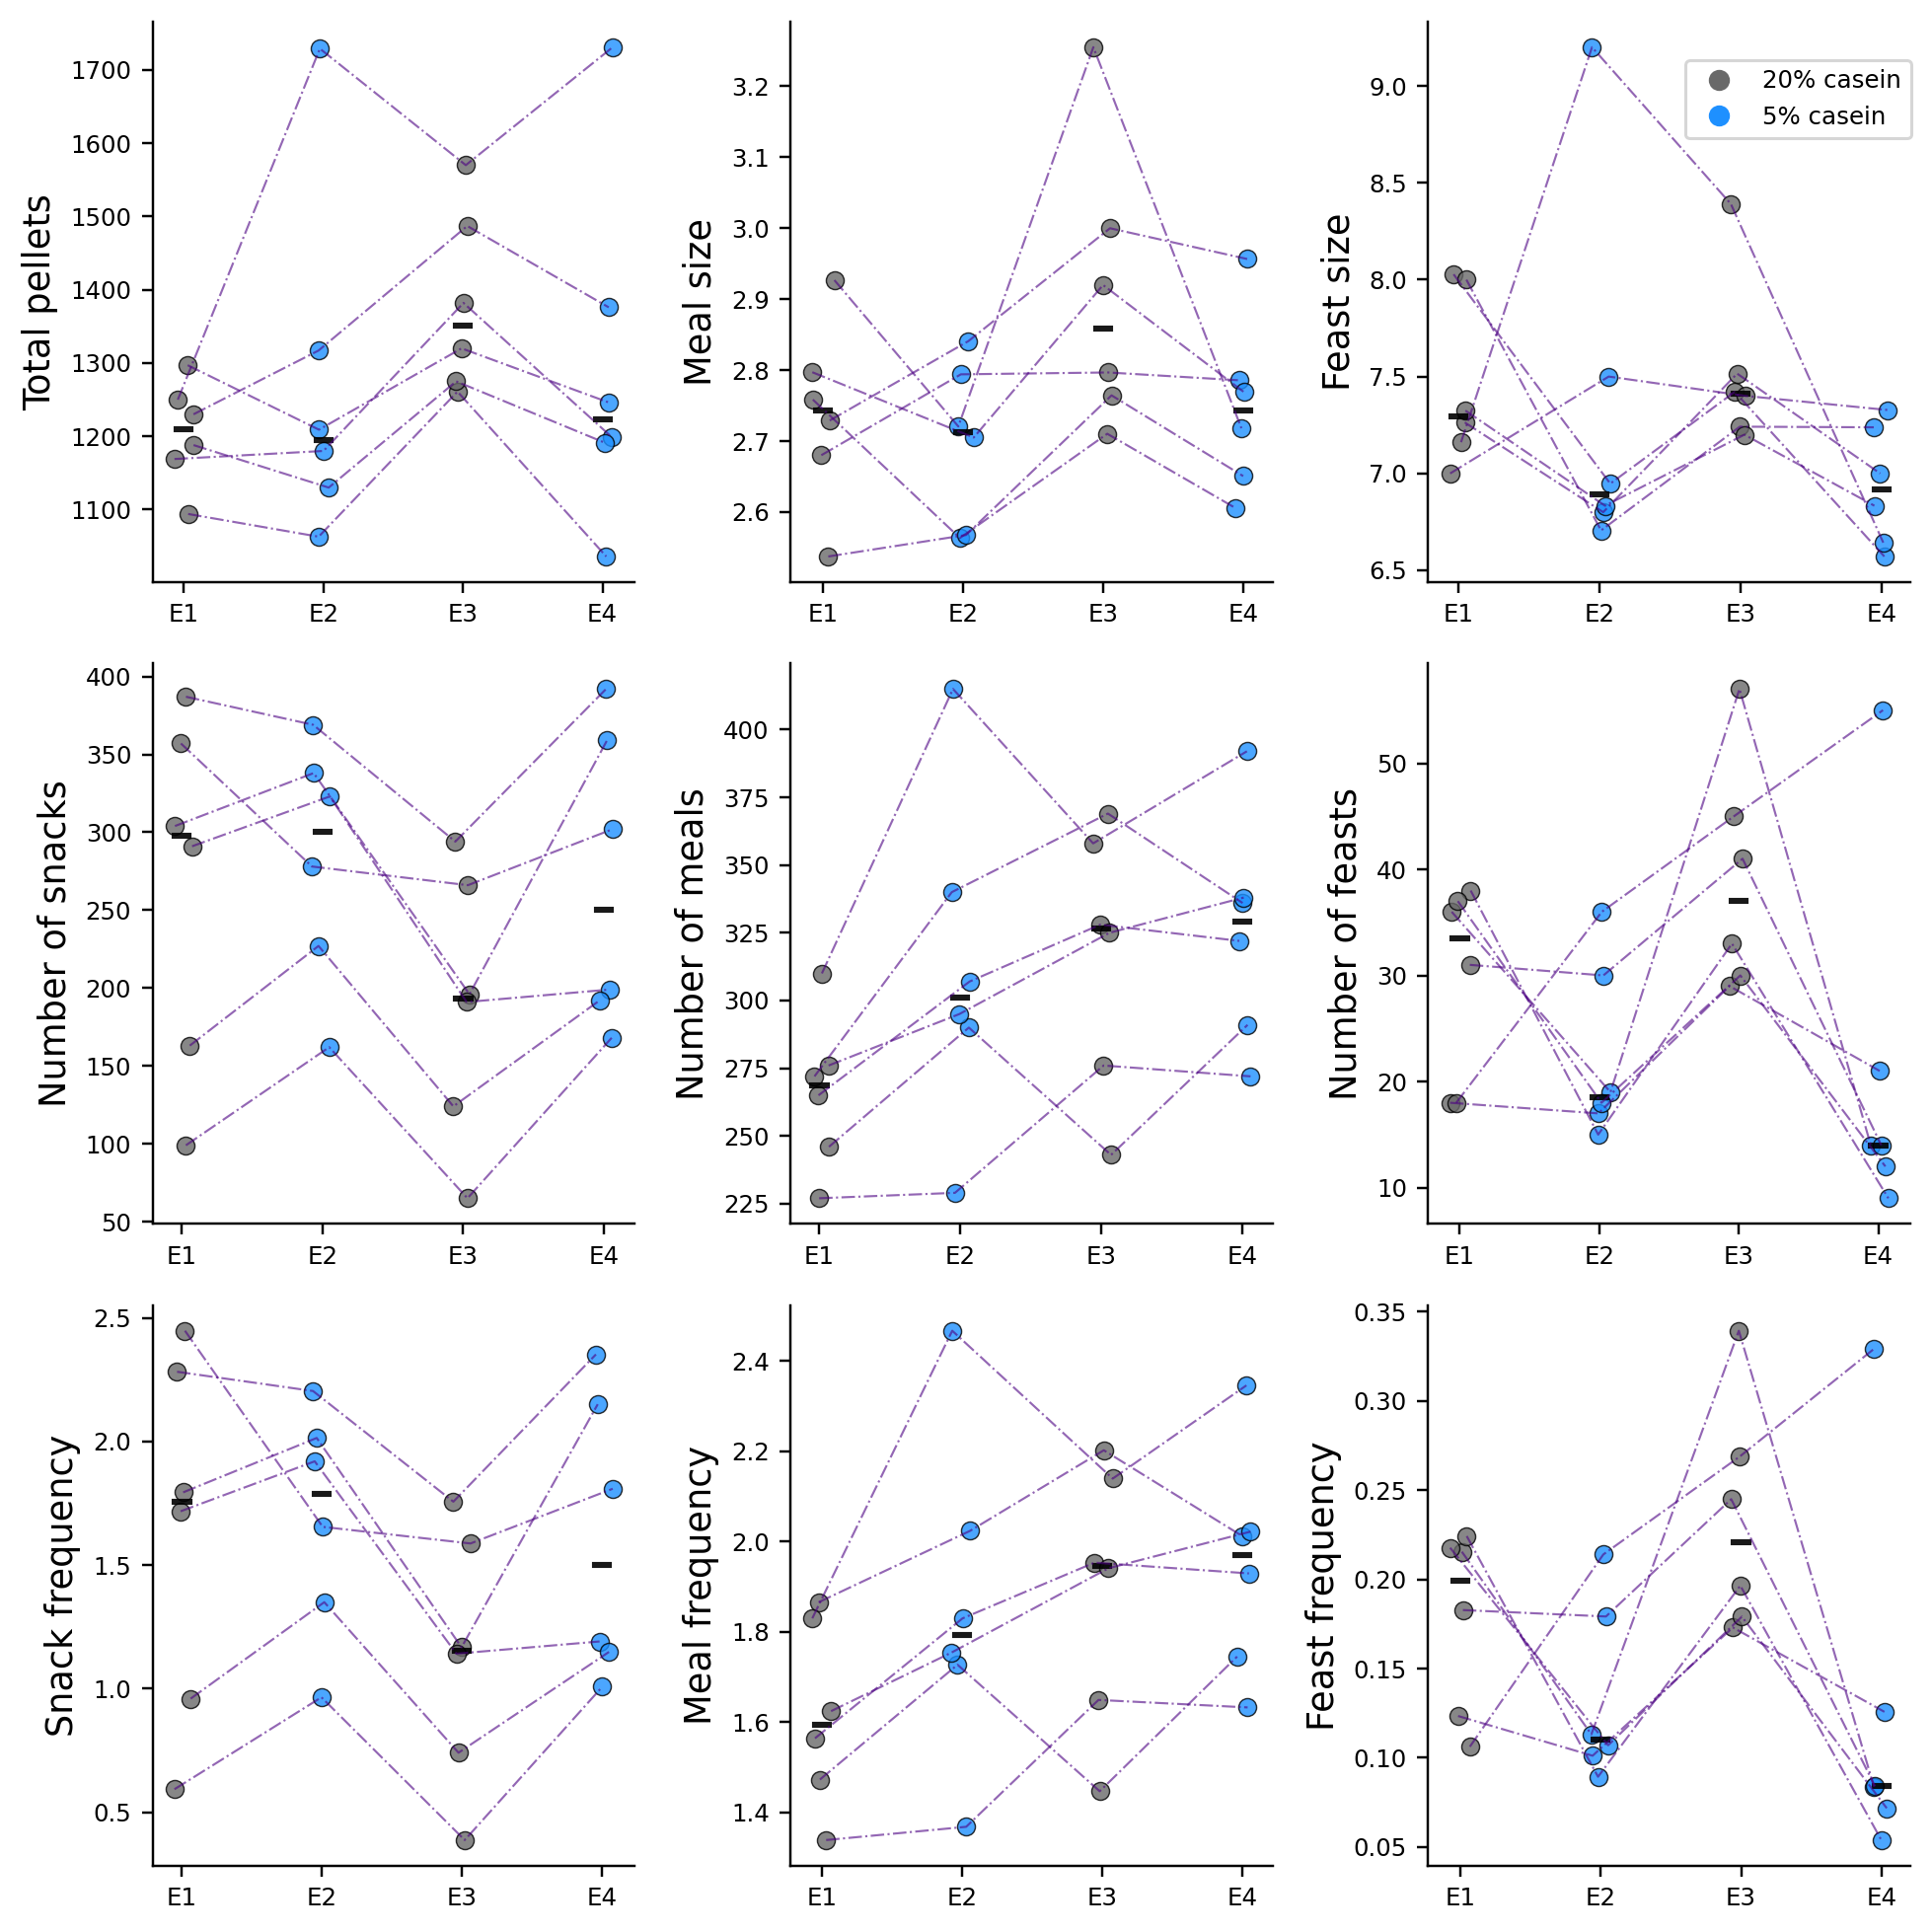

In [25]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from matplotlib.lines import Line2D

# ----------------------------------------------------------------
# 1. Load CSV and convert columns to lists
# ----------------------------------------------------------------
epoch_results_path = "epoch_analysis_results_V5.csv"
epoch_results_df = pd.read_csv(epoch_results_path)

def convert_to_list(value):
    try:
        if isinstance(value, str):
            return ast.literal_eval(value)
        elif isinstance(value, (int, float)):
            return [value]  # wrap single numeric value in a list
        else:
            return value
    except (SyntaxError, ValueError):
        return []

# Apply conversion to relevant columns
for epoch in ["E1", "E2", "E3", "E4"]:
    for metric in [
        "number_of_snacks", "number_of_meals", "number_of_mega_meals",
        "meal_size", "mega_meal_size", "snack_frequency", "meal_frequency",
        "mega_meal_frequency", "pellets_per_day"
    ]:
        col = f"epoch_{epoch}_{metric}"
        if col in epoch_results_df.columns:
            epoch_results_df[col] = epoch_results_df[col].apply(convert_to_list)

# ----------------------------------------------------------------
# 2. Sum metrics per epoch (excluding first 2 days in E1)
# ----------------------------------------------------------------
metrics_to_plot = [
    "number_of_snacks", "number_of_meals", "number_of_mega_meals",
    "meal_size", "mega_meal_size", "snack_frequency", "meal_frequency",
    "mega_meal_frequency", "pellets_per_day"
]

# Prepare dict to store sums
total_metrics_per_epoch = {
    metric: {
        epoch: {"Order 1": [], "Order 2": []}
        for epoch in ["E1", "E2", "E3", "E4"]
    } for metric in metrics_to_plot
}

# Populate sums for each mouse
for _, row in epoch_results_df.iterrows():
    order_str = f"Order {row['order']}"
    for epoch in ["E1", "E2", "E3", "E4"]:
        for metric in metrics_to_plot:
            metric_data = row[f"epoch_{epoch}_{metric}"]
            if not isinstance(metric_data, list):
                metric_data = [metric_data]
            # Exclude first 2 days for E1
            if epoch == "E1" and len(metric_data) > 2:
                metric_data = metric_data[2:]
            total_value = sum(metric_data)
            total_metrics_per_epoch[metric][epoch][order_str].append(total_value)

# ----------------------------------------------------------------
# 3. Metric label mapping (capitalize first letter, rest lower)
#    with 'mega meals' -> 'feasts'
# ----------------------------------------------------------------
rename_labels = {
    "pellets_per_day":        "Total pellets",
    "meal_size":              "Meal size",
    "mega_meal_size":         "Feast size",
    "number_of_snacks":       "Number of snacks",
    "number_of_meals":        "Number of meals",
    "number_of_mega_meals":   "Number of feasts",
    "snack_frequency":        "Snack frequency",
    "meal_frequency":         "Meal frequency",
    "mega_meal_frequency":    "Feast frequency"
}

def get_ylabel(metric):
    """Return a custom label for the metric."""
    return rename_labels.get(metric, metric)

# ----------------------------------------------------------------
# 4. Plotting helper: a single metric for Order 2
# ----------------------------------------------------------------
def plot_metric_for_order2(ax, metric, total_dict):
    """Scatter + median line + connecting lines for Order 2 (E1–E4)."""
    epochs = ["E1", "E2", "E3", "E4"]
    x_positions = {"E1": 0, "E2": 1, "E3": 2, "E4": 3}
    epoch_colors = {"E1": "dimgray", "E2": "dodgerblue", 
                    "E3": "dimgray", "E4": "dodgerblue"}
    jitter_strength = 0.08
    
    # Extract data
    order2_data_by_epoch = {ep: total_dict[metric][ep]["Order 2"] for ep in epochs}
    num_mice = len(order2_data_by_epoch["E1"])
    
    # Plot each epoch with jitter + median
    jittered_x_positions = {}
    for ep in epochs:
        x_pos = x_positions[ep]
        data = order2_data_by_epoch[ep]
        jittered_x = [x_pos + np.random.uniform(-jitter_strength, jitter_strength) 
                      for _ in data]
        jittered_x_positions[ep] = jittered_x
        
        sns.scatterplot(
            x=jittered_x, y=data, ax=ax,
            color=epoch_colors[ep], edgecolor="black",
            marker='o', s=35, alpha=0.8
        )
        
        # Median line
        median_val = np.median(data) if len(data) > 0 else 0
        ax.plot([x_pos - 0.05, x_pos + 0.05], [median_val, median_val],
                color='black', linewidth=2, alpha=0.9)
    
    # Connect each mouse's data across epochs
    for i in range(num_mice):
        x_line = [jittered_x_positions[ep][i] for ep in epochs]
        y_line = [order2_data_by_epoch[ep][i] for ep in epochs]
        ax.plot(x_line, y_line, color='indigo', linestyle='-.',
                linewidth=0.7, alpha=0.6)
    
    # Axis formatting
    ax.set_xticks([x_positions[ep] for ep in epochs])
    ax.set_xticklabels(epochs, fontsize=8)  # smaller tick labels
    ax.tick_params(axis='both', labelsize=8)
    ax.set_ylabel(get_ylabel(metric), fontsize=12)
    sns.despine(ax=ax)

# ----------------------------------------------------------------
# 5. Single figure, 3 rows × 3 columns
#    Row1: [pellets_per_day, meal_size, mega_meal_size]
#    Row2: [number_of_snacks, number_of_meals, number_of_mega_meals]
#    Row3: [snack_frequency, meal_frequency, mega_meal_frequency]
# ----------------------------------------------------------------
all_metrics = [
    ["pellets_per_day", "meal_size", "mega_meal_size"],
    ["number_of_snacks", "number_of_meals", "number_of_mega_meals"],
    ["snack_frequency",  "meal_frequency",  "mega_meal_frequency"]
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9), dpi=220)

# If you’d like a uniform y-scale per row, consider sharey='row',
# but each metric might differ in scale, so we use sharey=False.

for r in range(3):
    for c in range(3):
        metric = all_metrics[r][c]
        ax = axes[r][c]
        plot_metric_for_order2(ax, metric, total_metrics_per_epoch)

# Create a single legend in the top-right corner of the figure
custom_legend = [
    Line2D([0], [0], marker='o', linestyle='', 
           color='dimgray', markerfacecolor='dimgray',
           label='20% casein', markersize=6),
    Line2D([0], [0], marker='o', linestyle='',
           color='dodgerblue', markerfacecolor='dodgerblue',
           label='5% casein', markersize=6)
]

# Position the legend at the top-right outside the subplot grid
fig.legend(
    handles=custom_legend,
    loc="upper right", bbox_to_anchor=(0.99, 0.97),
    frameon=True, fontsize=8
)

plt.tight_layout()
plt.show()

# Save if desired:
# fig.savefig("AllMetrics_OneFigure.png", bbox_inches='tight', dpi=150)


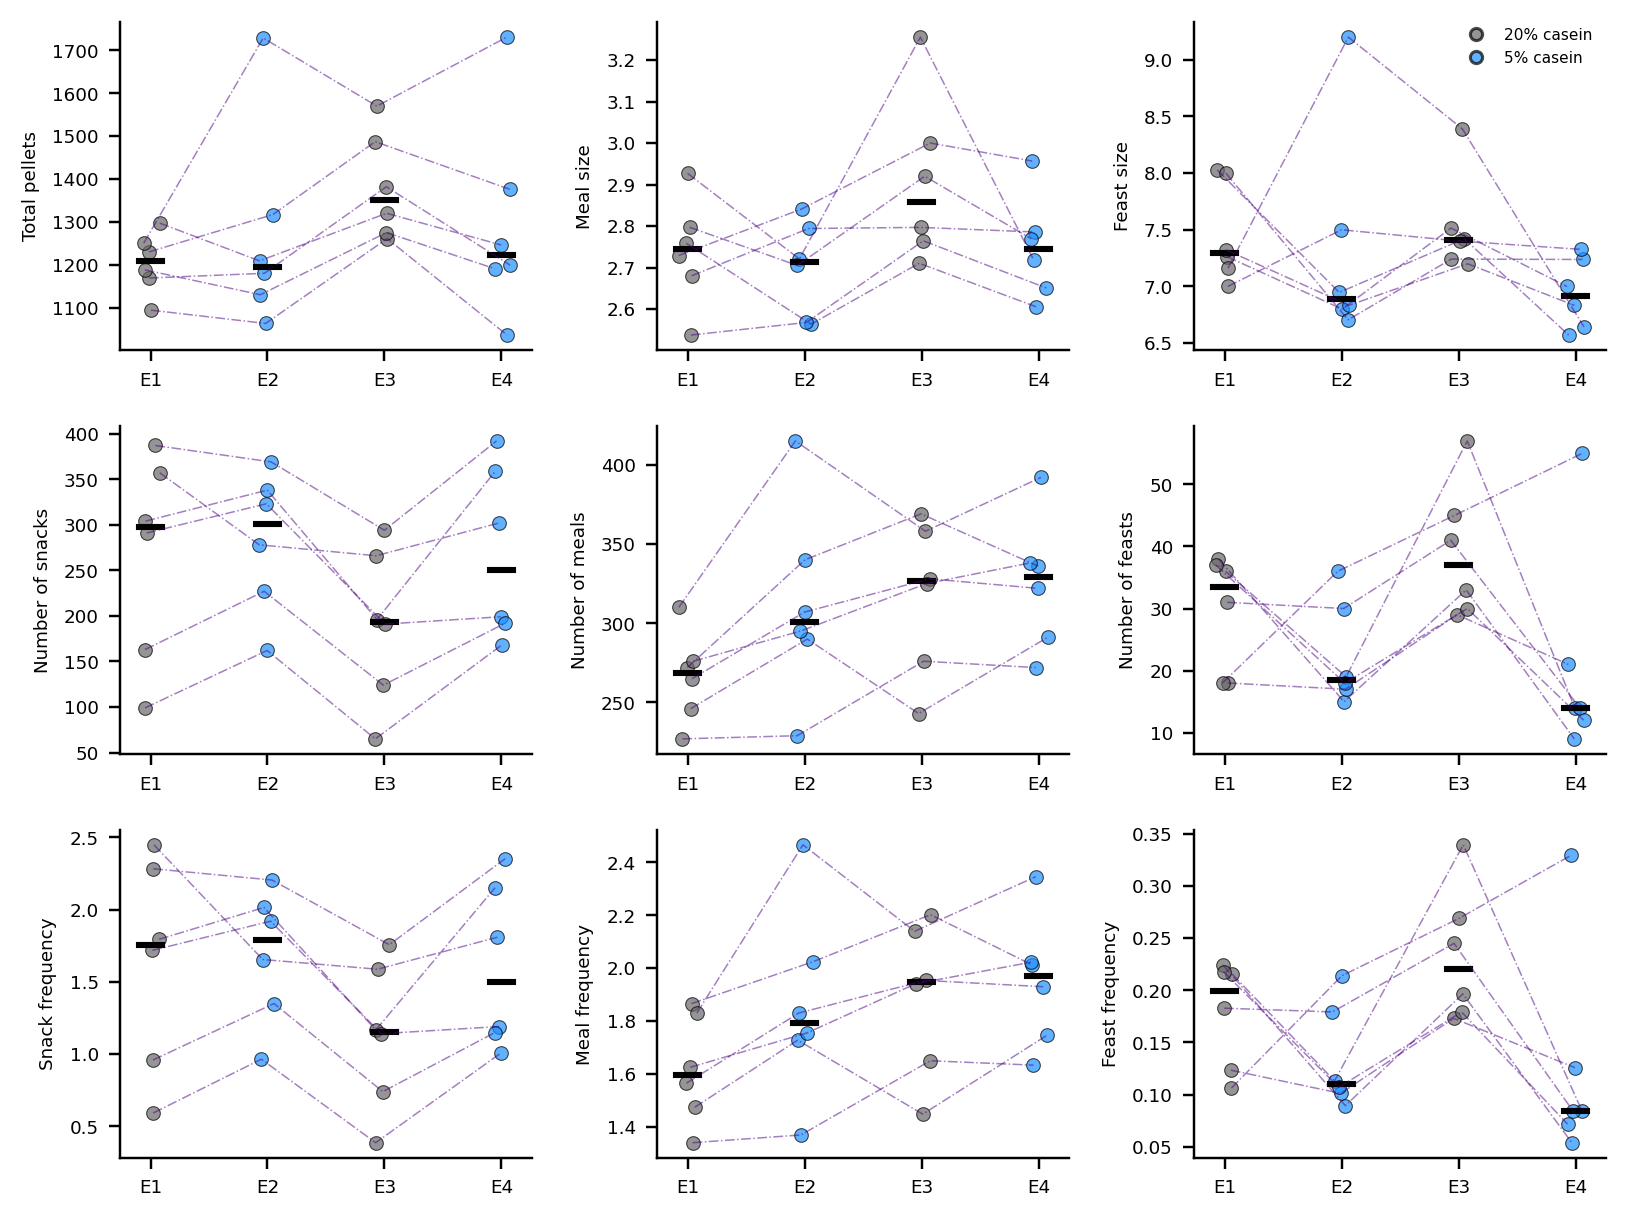

In [39]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from matplotlib.lines import Line2D

###############################################################################
# 1. Load CSV and convert columns to lists
###############################################################################
epoch_results_path = "epoch_analysis_results_V5.csv"
epoch_results_df = pd.read_csv(epoch_results_path)

def convert_to_list(value):
    try:
        if isinstance(value, str):
            return ast.literal_eval(value)
        elif isinstance(value, (int, float)):
            return [value]  # wrap single numeric value in a list
        else:
            return value
    except (SyntaxError, ValueError):
        return []

# Apply conversion to relevant columns
for epoch in ["E1", "E2", "E3", "E4"]:
    for metric in [
        "number_of_snacks", "number_of_meals", "number_of_mega_meals",
        "meal_size", "mega_meal_size", "snack_frequency", "meal_frequency",
        "mega_meal_frequency", "pellets_per_day"
    ]:
        col = f"epoch_{epoch}_{metric}"
        if col in epoch_results_df.columns:
            epoch_results_df[col] = epoch_results_df[col].apply(convert_to_list)

###############################################################################
# 2. Sum metrics per epoch (excluding first 2 days in E1)
###############################################################################
metrics_to_plot = [
    "number_of_snacks", "number_of_meals", "number_of_mega_meals",
    "meal_size", "mega_meal_size", "snack_frequency", "meal_frequency",
    "mega_meal_frequency", "pellets_per_day"
]

# Prepare dict to store sums
total_metrics_per_epoch = {
    metric: {
        epoch: {"Order 1": [], "Order 2": []}
        for epoch in ["E1", "E2", "E3", "E4"]
    } for metric in metrics_to_plot
}

# Populate sums for each mouse
for _, row in epoch_results_df.iterrows():
    order_str = f"Order {row['order']}"
    for epoch in ["E1", "E2", "E3", "E4"]:
        for metric in metrics_to_plot:
            metric_data = row[f"epoch_{epoch}_{metric}"]
            if not isinstance(metric_data, list):
                metric_data = [metric_data]
            # Exclude first 2 days for E1
            if epoch == "E1" and len(metric_data) > 2:
                metric_data = metric_data[2:]
            total_value = sum(metric_data)
            total_metrics_per_epoch[metric][epoch][order_str].append(total_value)

###############################################################################
# 3. Metric label mapping
###############################################################################
rename_labels = {
    "pellets_per_day":        "Total pellets",
    "meal_size":              "Meal size",
    "mega_meal_size":         "Feast size",
    "number_of_snacks":       "Number of snacks",
    "number_of_meals":        "Number of meals",
    "number_of_mega_meals":   "Number of feasts",
    "snack_frequency":        "Snack frequency",
    "meal_frequency":         "Meal frequency",
    "mega_meal_frequency":    "Feast frequency"
}

def get_ylabel(metric):
    return rename_labels.get(metric, metric)

###############################################################################
# 4. Plotting helper: a single metric for Order 2
###############################################################################
def plot_metric_for_order2(ax, metric, total_dict):
    """
    Scatter + median line + connecting lines for Order 2 (E1–E4),
    with small markers, alpha=0.7, no custom y-ticks, and a thicker median line.
    """
    epochs = ["E1", "E2", "E3", "E4"]
    x_positions = {"E1": 0, "E2": 1, "E3": 2, "E4": 3}
    epoch_colors = {"E1": "dimgray", "E2": "dodgerblue",
                    "E3": "dimgray", "E4": "dodgerblue"}
    jitter_strength = 0.08
    
    # Extract data for Order 2 only
    order2_data_by_epoch = {ep: total_dict[metric][ep]["Order 2"] for ep in epochs}
    num_mice = len(order2_data_by_epoch["E1"])
    
    # Plot each epoch with jitter + median
    jittered_x_positions = {}
    for ep in epochs:
        x_pos = x_positions[ep]
        data = order2_data_by_epoch[ep]
        # Jitter the x positions
        jittered_x = [
            x_pos + np.random.uniform(-jitter_strength, jitter_strength)
            for _ in data
        ]
        jittered_x_positions[ep] = jittered_x
        
        # Scatter plot
        sns.scatterplot(
            x=jittered_x, y=data, ax=ax,
            color=epoch_colors[ep], edgecolor="black",
            marker='o', s=20, alpha=0.7
        )
        
        # Median line (wider: linewidth=3)
        if len(data) > 0:
            median_val = np.median(data)
            ax.plot([x_pos - 0.1, x_pos + 0.1], [median_val, median_val],
                    color='black', linewidth=2, alpha=1.0)
    
    # Connect each mouse's data across epochs
    for i in range(num_mice):
        x_line = [jittered_x_positions[ep][i] for ep in epochs]
        y_line = [order2_data_by_epoch[ep][i] for ep in epochs]
        ax.plot(x_line, y_line, color='indigo', linestyle='-.', linewidth=0.5, alpha=0.5)
    
    # Axis formatting
    ax.set_xticks([x_positions[ep] for ep in epochs])
    ax.set_xticklabels(epochs, fontsize=6)
    ax.tick_params(axis='both', labelsize=6)
    ax.set_ylabel(get_ylabel(metric), fontsize=6)

    sns.despine(ax=ax)

###############################################################################
# 5. Single figure, 3 rows × 3 columns, each subplot ~2.5x1.88 inches
###############################################################################
all_metrics = [
    ["pellets_per_day", "meal_size", "mega_meal_size"],
    ["number_of_snacks", "number_of_meals", "number_of_mega_meals"],
    ["snack_frequency",  "meal_frequency",  "mega_meal_frequency"]
]

# Each subplot ~2.5x1.88, so total figure ~ (7.5, 5.64)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7.5, 5.64), dpi=220)
axes = axes.ravel()

flat_metrics = sum(all_metrics, [])  # Flatten 3×3 => 9 metrics
for i, metric in enumerate(flat_metrics):
    ax = axes[i]
    plot_metric_for_order2(ax, metric, total_metrics_per_epoch)

# Single legend in top-right corner
custom_legend = [
    Line2D([0], [0], marker='o', color='dimgray', linestyle='',
           label='20% casein', markerfacecolor='dimgray',
           markeredgecolor='black', markersize=4, alpha=0.7),
    Line2D([0], [0], marker='o', color='dodgerblue', linestyle='',
           label='5% casein', markerfacecolor='dodgerblue',
           markeredgecolor='black', markersize=4, alpha=0.7)
]

fig.legend(
    handles=custom_legend,
    loc="upper right", bbox_to_anchor=(0.98, 0.98),
    frameon=False, fontsize=5
)

plt.tight_layout()
plt.show()

# Save if needed:
# fig.savefig("AllMetrics_OneFigure_3x3.png", bbox_inches='tight', dpi=220)


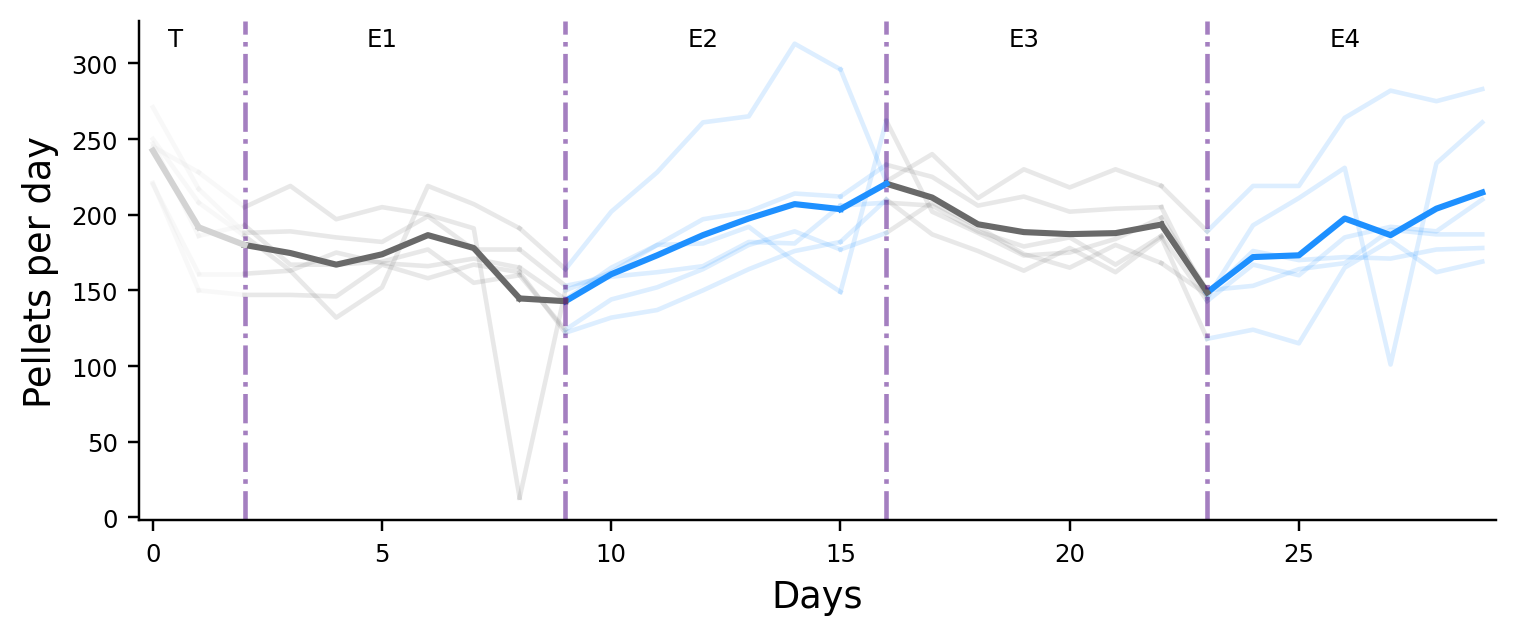

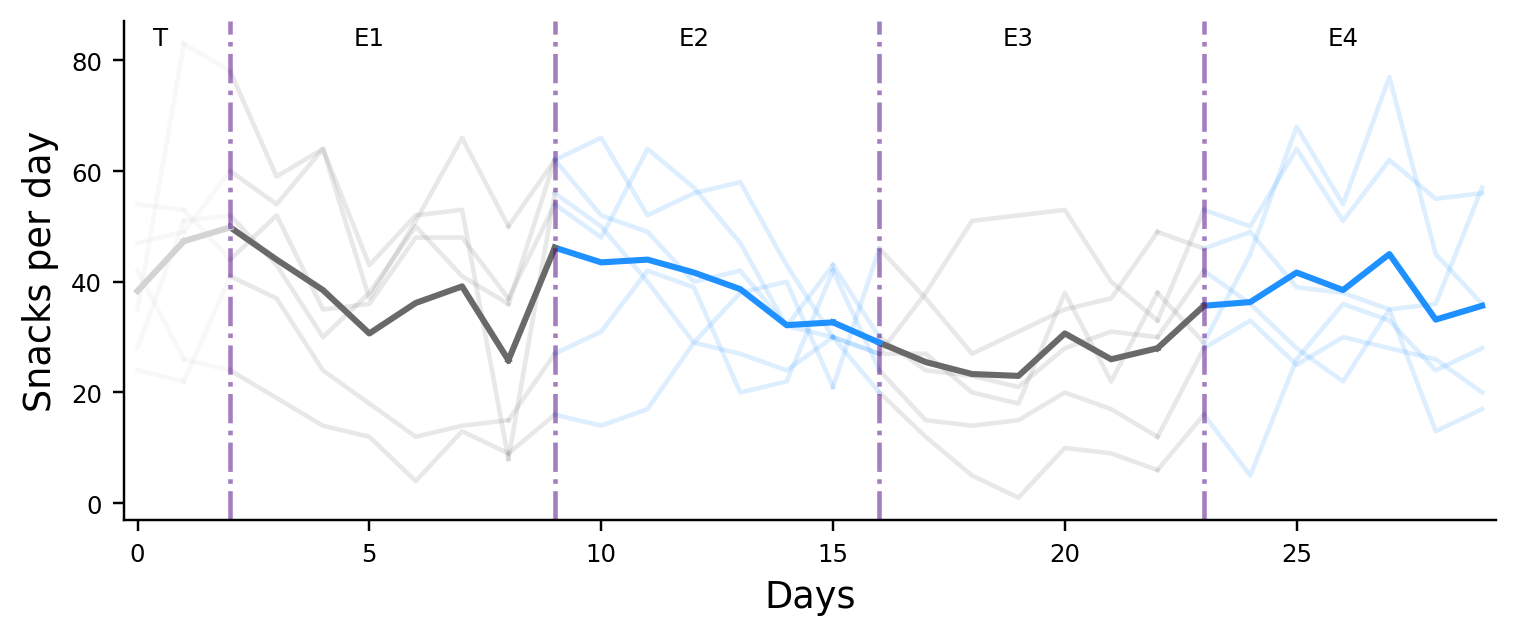

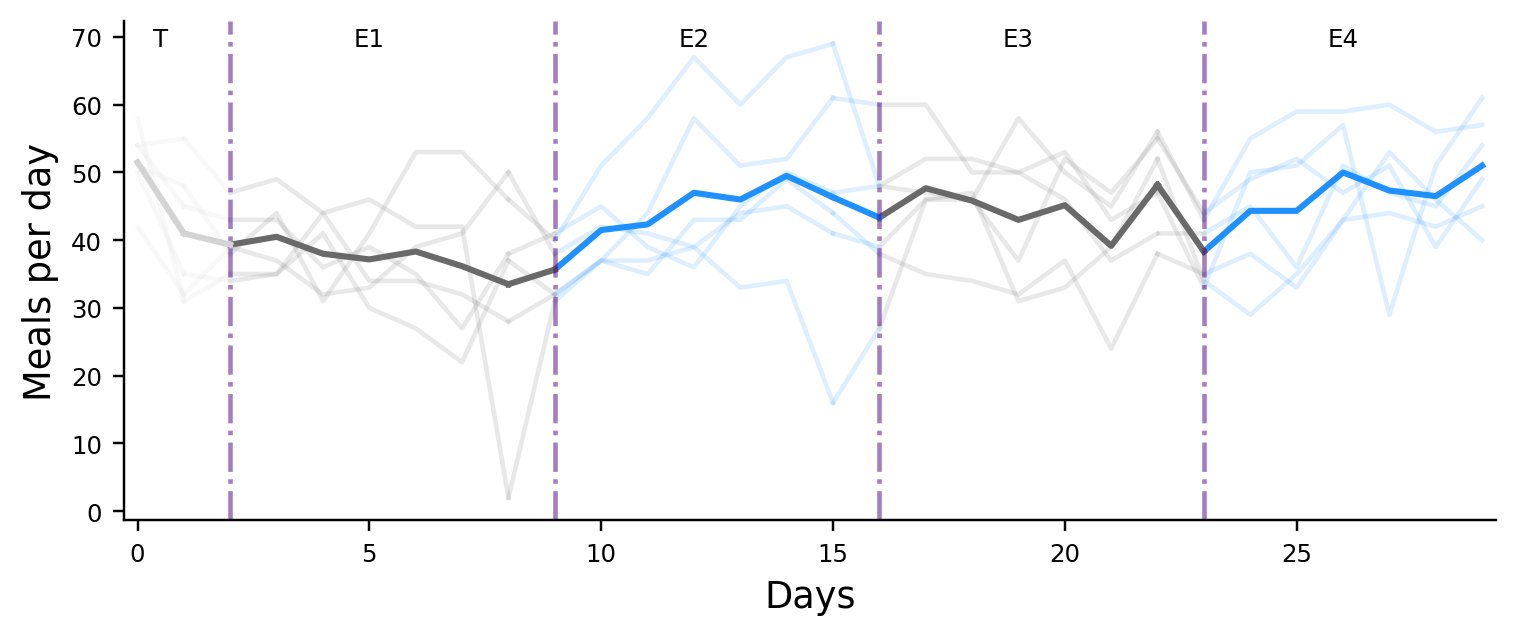

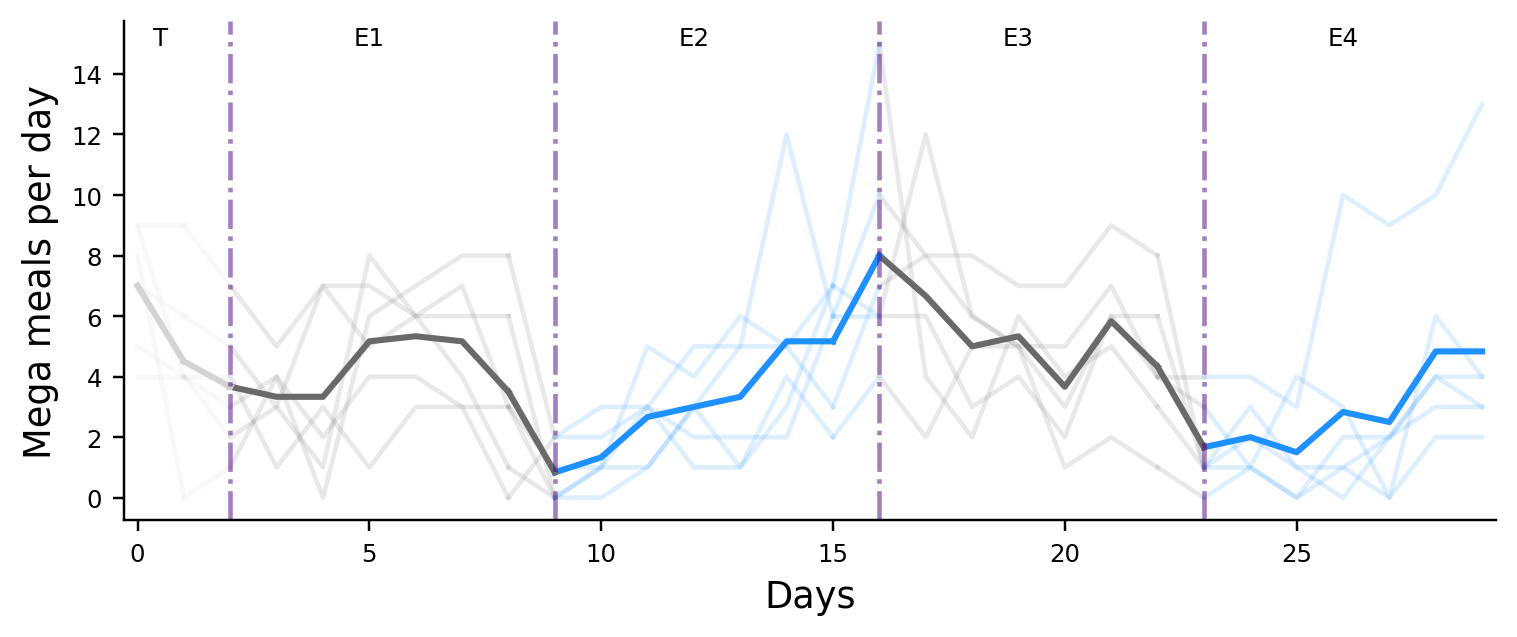

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

# -----------------------------
# 1. Load CSV and Filter for Order 2
# -----------------------------
csv_path = "epoch_analysis_results_V5.csv"
df = pd.read_csv(csv_path)
df_order2 = df[df["order"] == 2].copy()

# -----------------------------
# 2. Convert Per-Day Columns to Lists
# -----------------------------
def convert_to_list(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except:
        return []

metrics = ["pellets_per_day", "snacks_per_day", "meals_per_day", "mega_meals_per_day"]
epochs = ["E1", "E2", "E3", "E4"]

for epoch in epochs:
    for metric in metrics:
        col = f"epoch_{epoch}_{metric}"
        if col in df_order2.columns:
            df_order2[col] = df_order2[col].apply(convert_to_list)

# -----------------------------
# 3. Build Continuous Timeline for Each Metric
# -----------------------------
# E1 = 9 days (0–8); first 2 days (0–1) = training
# E2, E3, E4 = 7 days each => total 30 days (0–29)
def build_trace(row, metric):
    trace = []
    for epoch in epochs:
        col = f"epoch_{epoch}_{metric}"
        daily_vals = row.get(col, [])
        trace += daily_vals
    # Ensure we have exactly 30 days
    if len(trace) < 30:
        trace += [0]*(30-len(trace))
    return trace[:30]

order2_traces = {metric: [] for metric in metrics}

for _, row in df_order2.iterrows():
    for metric in metrics:
        day_by_day = build_trace(row, metric)
        order2_traces[metric].append(day_by_day)

for metric in metrics:
    order2_traces[metric] = np.array(order2_traces[metric])  # shape: (n_mice, 30)

# -----------------------------
# 4. Plotting Setup & Timeline (Order 2 Only)
# -----------------------------
# Segments:
#   Training = days 0–1 -> (0,2)
#   E1 = days 2–8       -> (2,9)
#   E2 = days 9–15      -> (9,16)
#   E3 = days 16–22     -> (16,23)
#   E4 = days 23–29     -> (23,30)
segments = [(0, 2), (2, 9), (9, 16), (16, 23), (23, 30)]
segment_labels = ["T", "E1", "E2", "E3", "E4"]

# Keep your original color pattern
segment_colors = ["lightgray", "dimgray", "dodgerblue", "dimgray", "dodgerblue"]

total_days = 30
ylabels = {
    "pellets_per_day": "Pellets per day",
    "snacks_per_day":  "Snacks per day",
    "meals_per_day":   "Meals per day",
    "mega_meals_per_day": "Mega meals per day"
}

for metric in metrics:
    data = order2_traces[metric]  # shape: (n_mice, 30)
    n_mice = data.shape[0]
    
    fig, ax = plt.subplots(figsize=(7, 3), dpi=220)
    
    # Plot each mouse's trace, segment-by-segment
    for i in range(n_mice):
        trace = data[i, :]
        for seg_idx, (start, end) in enumerate(segments):
            x_seg = np.arange(start, end)
            y_seg = trace[start:end]
            # Each segment in the color for that segment
            ax.plot(x_seg, y_seg, color=segment_colors[seg_idx], linestyle='-', alpha=0.15)
        # Connect boundaries with the color of the CURRENT segment
        for seg_idx in range(len(segments) - 1):
            boundary = segments[seg_idx][1]  # e.g. 2 -> 9 -> 16 -> 23
            if boundary - 1 < len(trace) and boundary < len(trace):
                x_connect = [boundary - 1, boundary]
                y_connect = [trace[boundary - 1], trace[boundary]]
                # Use the color of the current segment (seg_idx),
                # not seg_idx+1
                ax.plot(x_connect, y_connect, color=segment_colors[seg_idx], linestyle='-', alpha=0.15)
    
    # Overplot the mean trace in thicker lines
    mean_trace = np.nanmean(data, axis=0)
    for seg_idx, (start, end) in enumerate(segments):
        x_seg = np.arange(start, end)
        y_seg = mean_trace[start:end]
        ax.plot(x_seg, y_seg, color=segment_colors[seg_idx], linewidth=2)
    # Connect boundaries of the mean trace w/ the current segment color
    for seg_idx in range(len(segments) - 1):
        boundary = segments[seg_idx][1]
        if boundary - 1 < len(mean_trace) and boundary < len(mean_trace):
            x_connect = [boundary - 1, boundary]
            y_connect = [mean_trace[boundary - 1], mean_trace[boundary]]
            ax.plot(x_connect, y_connect, color=segment_colors[seg_idx], linewidth=2)
    
    # Vertical dashed lines at segment boundaries
    for boundary in [2, 9, 16, 23]:
        ax.axvline(boundary, linestyle='-.', color='indigo', alpha=0.5)
    
    # Segment labels (midpoints) near top
    y_top = ax.get_ylim()[1]
    for seg_idx, (start, end) in enumerate(segments):
        mid = (start + end - 1) / 2
        ax.text(mid, 0.95 * y_top, segment_labels[seg_idx], ha='center', fontsize=8)
    
    # X / Y labels and ticks
    ax.set_xlabel("Days", fontsize=12)
    ax.set_ylabel(ylabels[metric], fontsize=12)
    ax.set_xticks(range(0, total_days+1, 5))
    ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce tick size
    
    # Tiny gap on left/right
    ax.set_xlim(-0.3, 29.3)
    
    # Style: remove top/right spines, no grid
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    # Save if desired
    # fig.savefig(f"line_plot_{metric}_order2.png", bbox_inches='tight', dpi=220)


Saved global_30day_data.csv


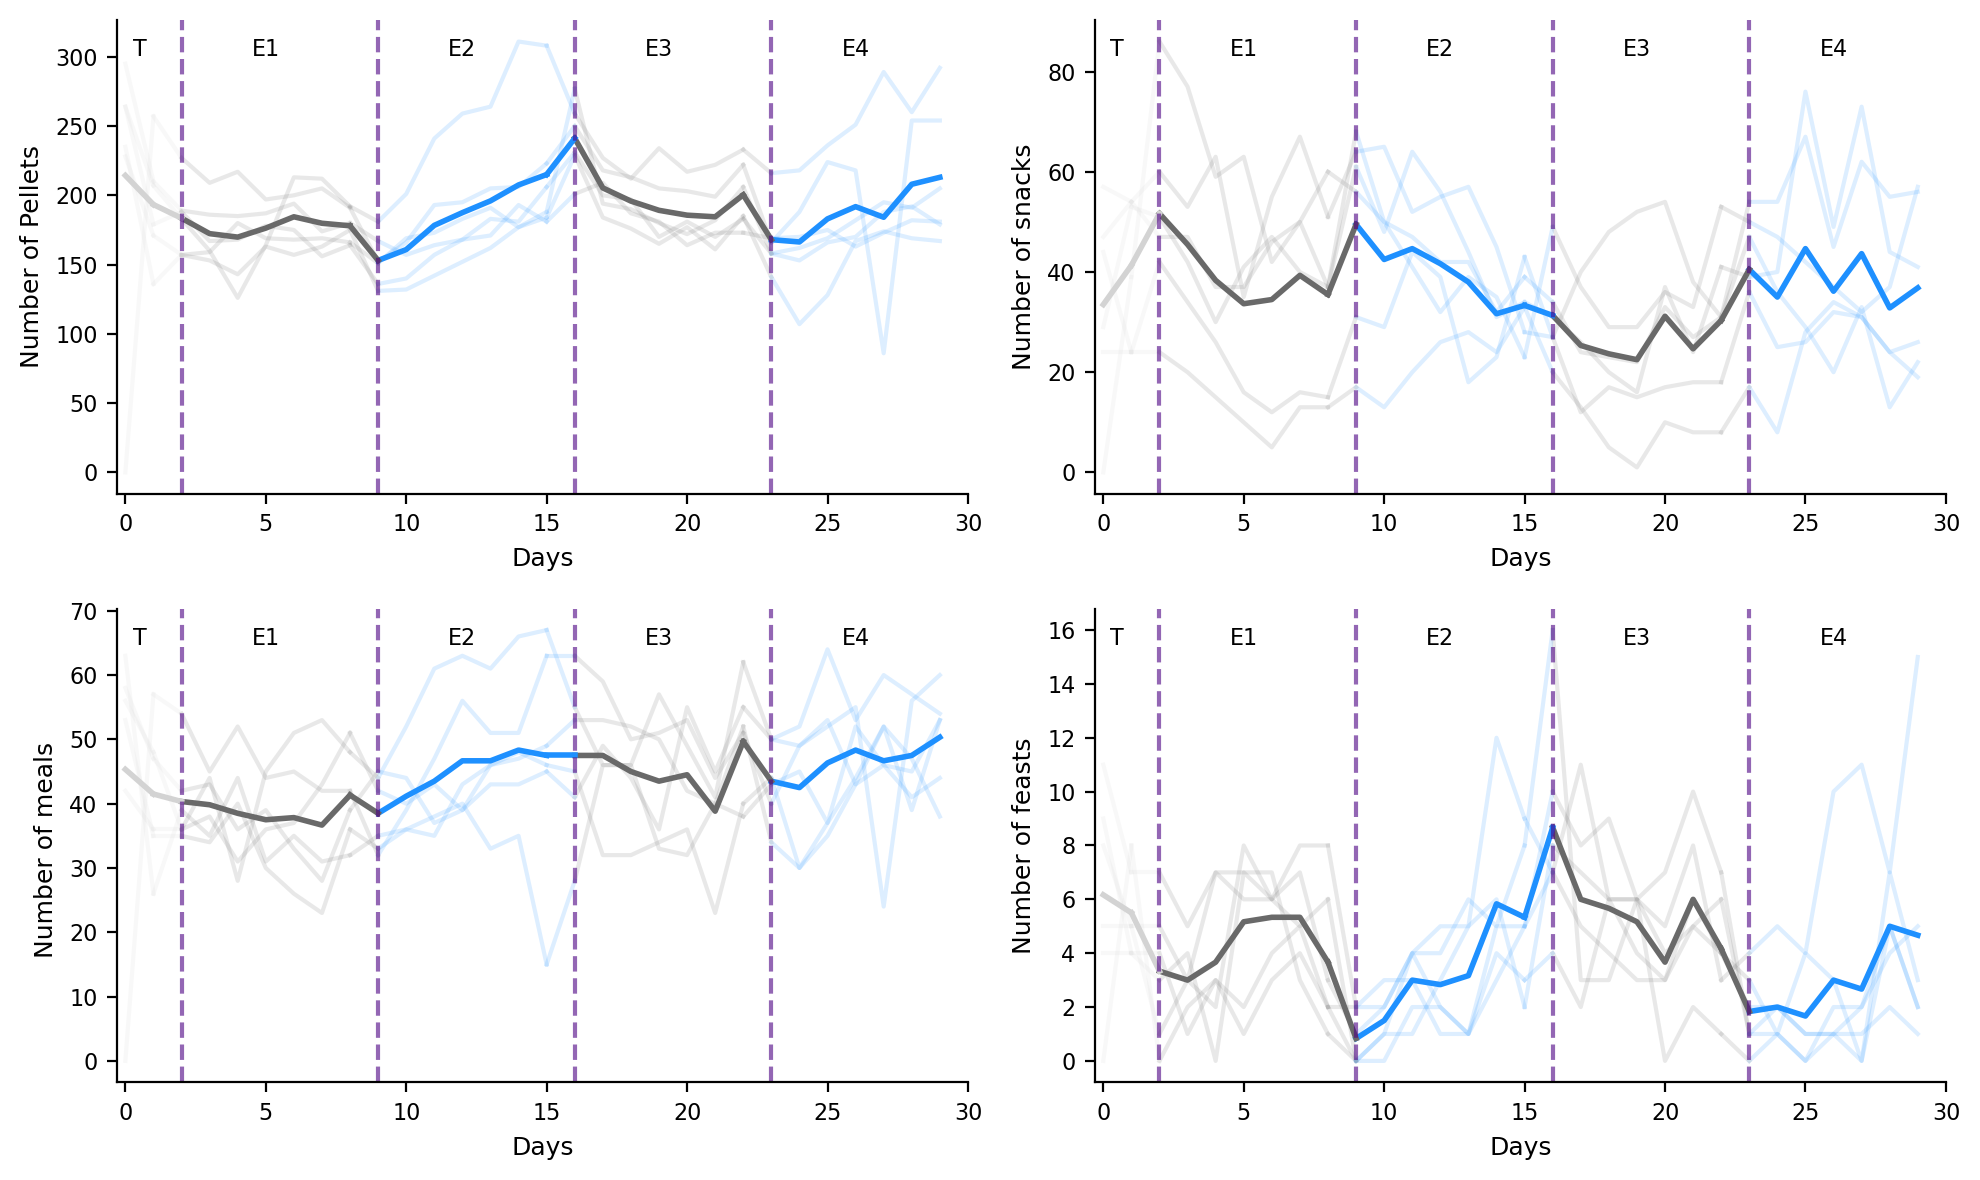

In [31]:
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

###############################################################################
# 1) Classification Helper 
###############################################################################
def classify_event(event, meals, snacks, mega_meals,
                   hourly_meals, hourly_snacks, hourly_mega_meals):
    """
    Classify a cluster of pellet times into 'snack', 'meal', or 'mega_meal'.
    Also increment an hourly counter, but in practice we won't plot the hourly
    counters here. We keep them for consistency with your original code.
    """
    size = len(event)
    day_index = int(event[0] // 24)
    hour = int(event[0] % 24)

    if size == 1:
        snacks.append(event)
        if 0 <= day_index < 7:
            hourly_snacks[day_index][hour] += 1
    elif 2 <= size <= 5:
        meals.append(event)
        if 0 <= day_index < 7:
            hourly_meals[day_index][hour] += 1
    else:
        mega_meals.append(event)
        if 0 <= day_index < 7:
            hourly_mega_meals[day_index][hour] += 1

###############################################################################
# 2) Minimal "Get Meal & Snack" Classification for a Single Day
###############################################################################
def classify_day_pellets(day_ts, meal_threshold=1/60):
    """
    Given all pellet timestamps for a single day (in hours from the experiment start),
    classify them into snacks, meals, mega_meals.
    
    Returns number_of_snacks, number_of_meals, number_of_mega_meals.
    """
    if not day_ts:
        return 0, 0, 0

    sorted_ts = sorted(day_ts)
    offset = sorted_ts[0]
    offset_ts = [t - offset for t in sorted_ts]

    IPIs = np.diff(np.array(offset_ts))

    tmp_meals, tmp_snacks, tmp_mega = [], [], []
    current_cluster = [offset_ts[0]]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_cluster.append(offset_ts[i+1])
        else:
            size = len(current_cluster)
            if size == 1:
                tmp_snacks.append(current_cluster)
            elif 2 <= size <= 5:
                tmp_meals.append(current_cluster)
            else:
                tmp_mega.append(current_cluster)
            current_cluster = [offset_ts[i+1]]

    # final cluster
    size = len(current_cluster)
    if size == 1:
        tmp_snacks.append(current_cluster)
    elif 2 <= size <= 5:
        tmp_meals.append(current_cluster)
    else:
        tmp_mega.append(current_cluster)

    return len(tmp_snacks), len(tmp_meals), len(tmp_mega)

###############################################################################
# 3) Parsing Each FED File in Absolute Datetime (No local offset)
###############################################################################
def parse_fedfile_absolute(filename, eventname="Pellet"):
    """
    Reads a single FED file and returns a list of *absolute* datetime objects
    for each event of `eventname`. We do NOT shift or offset them here; that
    will be done globally after we gather all events.
    """
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']

    try:
        with open(filename, 'r') as file:
            csvreader = csv.reader(file)
            header = next(csvreader)  # skip header
            rows = list(csvreader)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []

    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    # Detect date format from the first row
    test_datetime_str = rows[0][0]
    try:
        datetime.strptime(test_datetime_str, formats[0])
        date_format = formats[0]
    except ValueError:
        date_format = formats[1]

    dt_list = []
    for row in rows:
        if len(row) < 8:
            continue
        if row[7] == eventname:  # e.g. "Pellet"
            dt = datetime.strptime(row[0], date_format)
            dt_list.append(dt)

    return sorted(dt_list)

###############################################################################
# 4) Reading the Metafile & Building a Global Time Reference
###############################################################################
def process_metafile_global(metafile_path):
    """
    1) Reads the metafile CSV
    2) For each row, parse the FED file in absolute time
    3) Store the pellet datetimes in mice[mouse_id]["all_dt"]
    4) Find the earliest dt across *all* mice => global_start
    5) Convert each dt -> hours from global_start => mice[mouse_id]["all_hours"]
    6) Build day-by-day pellets, snacks, meals, mega-meals for 30 days
    7) Return the final dictionary: mice[mouse_id] with relevant day-by-day lists
    """
    fedfile_idx = 0
    mouse_idx   = 1
    sex_idx     = 4
    order_idx   = 5
    epoch_idx   = 6

    # 1) Read the metafile
    with open(metafile_path, 'r') as meta_f:
        meta_reader = csv.reader(meta_f)
        header = next(meta_reader)  # skip header
        rows = list(meta_reader)

    mice = {}
    all_datetimes = []

    for row in rows:
        if len(row) < 7:
            continue
        fedfile  = row[fedfile_idx]
        mouse_id = row[mouse_idx]
        sex      = row[sex_idx]
        order_   = row[order_idx]
        epoch    = row[epoch_idx] if len(row) > epoch_idx else ""

        if mouse_id not in mice:
            mice[mouse_id] = {
                "sex": sex,
                "order": int(order_) if order_.isdigit() else order_,
                "all_dt": [],
                "epochs": {}
            }

        fname = f"../data/{fedfile}"  # adapt path if needed
        dt_list = parse_fedfile_absolute(fname, eventname="Pellet")

        mice[mouse_id]["all_dt"].extend(dt_list)
        mice[mouse_id]["epochs"].setdefault(epoch, []).extend(dt_list)
        all_datetimes.extend(dt_list)

    if not all_datetimes:
        print("No pellet datetimes found in any file!")
        return mice

    # 2) Global start = earliest pellet in entire dataset
    global_start = min(all_datetimes)

    # 3) For each mouse, convert dt -> hours from global_start, then build day-by-day
    total_days = 30  # day indices 0..29
    for mouse_id, info in mice.items():
        info["all_dt"] = sorted(info["all_dt"])
        # hours from experiment start
        all_hours = [(dt - global_start).total_seconds()/3600.0 for dt in info["all_dt"]]
        info["all_hours"] = sorted(all_hours)

        # Build day-by-day metrics:
        pellets_per_day    = [0]*total_days
        snacks_per_day     = [0]*total_days
        meals_per_day      = [0]*total_days
        mega_meals_per_day = [0]*total_days

        for d in range(total_days):
            day_start = d * 24
            day_end   = (d + 1) * 24
            day_ts    = [t for t in all_hours if day_start <= t < day_end]

            pellets_per_day[d] = len(day_ts)
            s, m, mm = classify_day_pellets(day_ts)
            snacks_per_day[d]     = s
            meals_per_day[d]      = m
            mega_meals_per_day[d] = mm

        # Store them
        info["pellets_per_day"]    = pellets_per_day
        info["snacks_per_day"]     = snacks_per_day
        info["meals_per_day"]      = meals_per_day
        info["mega_meals_per_day"] = mega_meals_per_day

    return mice

###############################################################################
# 5) Plot in a Single Figure for order=2
###############################################################################
def plot_30day_metrics(mice):
    """
    Plots only mice with 'order' == 2, and creates a single figure with
    4 subplots (pellets, snacks, meals, mega meals).
    """
    total_days = 30
    metrics = ["pellets_per_day", "snacks_per_day", "meals_per_day", "mega_meals_per_day"]
    ylabels = {
        "pellets_per_day":    "Number of Pellets",
        "snacks_per_day":     "Number of snacks",
        "meals_per_day":      "Number of meals ",
        "mega_meals_per_day":"Number of feasts"
    }

    # Gather data for mice of order=2 only
    # We'll build a dict: data_dict[metric] = 2D np.array (n_mice, 30)
    data_dict = {m: [] for m in metrics}
    
    mouse_ids_order2 = []
    for mid, info in mice.items():
        if info["order"] == 2:
            mouse_ids_order2.append(mid)
            for metric in metrics:
                data_dict[metric].append(info[metric])

    # If no mice of order=2 found, just return
    if not mouse_ids_order2:
        print("No mice with order=2 found!")
        return

    # Convert each list of lists to numpy array
    for m in metrics:
        data_dict[m] = np.array(data_dict[m], dtype=float)  # shape: (n_mice, 30)

    segments = [(0,2), (2,9), (9,16), (16,23), (23,30)]
    segment_labels = ["T","E1","E2","E3","E4"]
    segment_colors = ["lightgray","dimgray","dodgerblue","dimgray","dodgerblue"]

    # Create one figure with 4 subplots in a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=200)
    axes = axes.ravel()  # flatten to [ax0, ax1, ax2, ax3]

    for i, metric in enumerate(metrics):
        ax = axes[i]
        data = data_dict[metric]  # shape: (n_mice, 30)
        n_mice = data.shape[0]

        # Plot each mouse's line, colored by segment
        for row_i in range(n_mice):
            trace = data[row_i,:]
            # draw segment by segment
            for seg_i, (start, end) in enumerate(segments):
                x_seg = np.arange(start, end)
                y_seg = trace[start:end]
                ax.plot(x_seg, y_seg, color=segment_colors[seg_i], alpha=0.15)

            # Optionally connect boundary points
            for seg_i in range(len(segments) - 1):
                boundary = segments[seg_i][1]  # e.g. 2, 9, 16, 23
                if boundary - 1 < total_days and boundary < total_days:
                    x_con = [boundary - 1, boundary]
                    y_con = [trace[boundary - 1], trace[boundary]]
                    ax.plot(x_con, y_con, color=segment_colors[seg_i], alpha=0.15)

        # Overplot the mean in thicker lines
        mean_trace = np.nanmean(data, axis=0)
        for seg_i, (start, end) in enumerate(segments):
            x_seg = np.arange(start, end)
            y_seg = mean_trace[start:end]
            ax.plot(x_seg, y_seg, color=segment_colors[seg_i], linewidth=2)

        # Connect mean boundary points
        for seg_i in range(len(segments) - 1):
            boundary = segments[seg_i][1]
            x_con = [boundary - 1, boundary]
            y_con = [mean_trace[boundary - 1], mean_trace[boundary]]
            ax.plot(x_con, y_con, color=segment_colors[seg_i], linewidth=2)

        # Vertical dashed lines
        for xline in [2, 9, 16, 23]:
            ax.axvline(xline, linestyle="--", color="indigo", alpha=0.6)

        # Segment labels near the top
        y_top = ax.get_ylim()[1]
        for seg_i, (start, end) in enumerate(segments):
            mid = (start + end - 1)/2
            ax.text(mid, 0.92*y_top, segment_labels[seg_i], ha="center", fontsize=8)

        ax.set_xlim(-0.3, 29.3)
        ax.set_xlabel("Days", fontsize=9)
        ax.set_ylabel(ylabels[metric], fontsize=9)
        ax.set_xticks(range(0,31,5))
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(False)

    plt.tight_layout()
    plt.show()

###############################################################################
# 6) Main Script
###############################################################################
if __name__ == "__main__":
    # 1) Read + parse the metafile in a single global timeline
    metafile_path = "../FEDXC_METAFILE.csv"
    mice_data = process_metafile_global(metafile_path)

    # 2) (Optional) Save the day-by-day data
    rows_for_csv = []
    for m_id, info in mice_data.items():
        row = {
            "mouse_id": m_id,
            "sex": info["sex"],
            "order": info["order"],
            "pellets_per_day":    str(info["pellets_per_day"]),
            "snacks_per_day":     str(info["snacks_per_day"]),
            "meals_per_day":      str(info["meals_per_day"]),
            "mega_meals_per_day": str(info["mega_meals_per_day"]),
        }
        rows_for_csv.append(row)

    df_out = pd.DataFrame(rows_for_csv)
    df_out.to_csv("global_30day_data.csv", index=False)
    print("Saved global_30day_data.csv")

    # 3) Plot only mice with order=2 in one figure with 4 subplots
    plot_30day_metrics(mice_data)
